#  Salary Prediction 

This notebook serves as the entry point for our salary prediction pipeline.

It reads the input dataset, performs cleaning and transformation, trains a model, and evaluates its performance.
The core idea is to build a simple but modular pipeline which is flexible enough to incorporate aditional features and models.

---

##  Table of Contents

1. [Imports and raw data](#imports)  
2. [EDA – Raw Data Check](#eda-raw)  
3. [EDA – Visual Exploration](#eda-visual)  
4. [Preprocessing](#preprocessing)  
5. [Feature Transformation](#features)  
6. [Model Training & Evaluation](#model)
7. [Predicting on New Input Data](#7-predicting-on-new-input-data)


###  1. Imports and raw data

All core libraries (Pandas, NumPy, Seaborn...) and our own modular code from `src/`.


In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os


from src.preprocessing import prepare_data
from src import eda
from src.features import transform_features
from src.model import split_data, train_model, evaluate_model
from src.predict import predict_from_csv
from src.optional_feats import plot_numeric_feature_vs_target, plot_categorical_feature_vs_target
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

#Load raw data (people and salary info)
df_people = pd.read_csv("data/people.csv")
df_salary = pd.read_csv("data/salary.csv")



###  2. EDA – Raw Data Check

Before running the pipeline, we quickly check for:
- Consistency between the two CSV files (people & salary)
- Null values
- General data structure

This is optional but helps ensure the data looks clean enough to proceed.


In [2]:
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)  
pd.set_option('display.expand_frame_repr', False)  



#Check consistency in both df
eda.check_id_consistency(df_people, df_salary)

#Check how many nulls are present in people.csv
eda.check_nulls(df_people, name="people.csv")


df_merged = df_people.merge(df_salary, on="id", how="left")

# Check how many rows of salary has nulls.
eda.count_salary_nulls(df_merged)

# Count and display rows that have at least one null value
eda.count_rows_with_any_null(df_merged, name="merged df")

#Print shape, types and head of the merged dataset
eda.print_df_overview(df_merged, name="merged df")



IDs in people.csv which are not in salary.csv: 0
IDs in salary.csv which are not in people.csv: 0

 amount of nulls per column people.csv:
id                     0
Age                    5
Gender                 5
Education Level        5
Job Title              5
Years of Experience    2
dtype: int64

 rows in salary that are null: 2

 amount of rows that have at least a NaN value: 14
      id   Age  Gender Education Level                         Job Title  Years of Experience    Salary
51    51  33.0    Male        Master's                               NaN                  7.0   85000.0
60    60  51.0  Female        Master's                               NaN                 23.0  170000.0
139  139  43.0  Female             NaN  Senior Product Marketing Manager                 14.0  120000.0
172  172   NaN     NaN             NaN                               NaN                  NaN       NaN
219  219  40.0     NaN      Bachelor's       Senior Sales Representative                 12.

###  3. EDA – Visual Exploration

Here we look at the distribution of variables like Age, Salary, and Years of Experience.

Also checks how many job titles appear more than a threshold.  
It helps us decide which ones to group under "Other".
Includes information related to the Gender Variable. See README.md for more information.


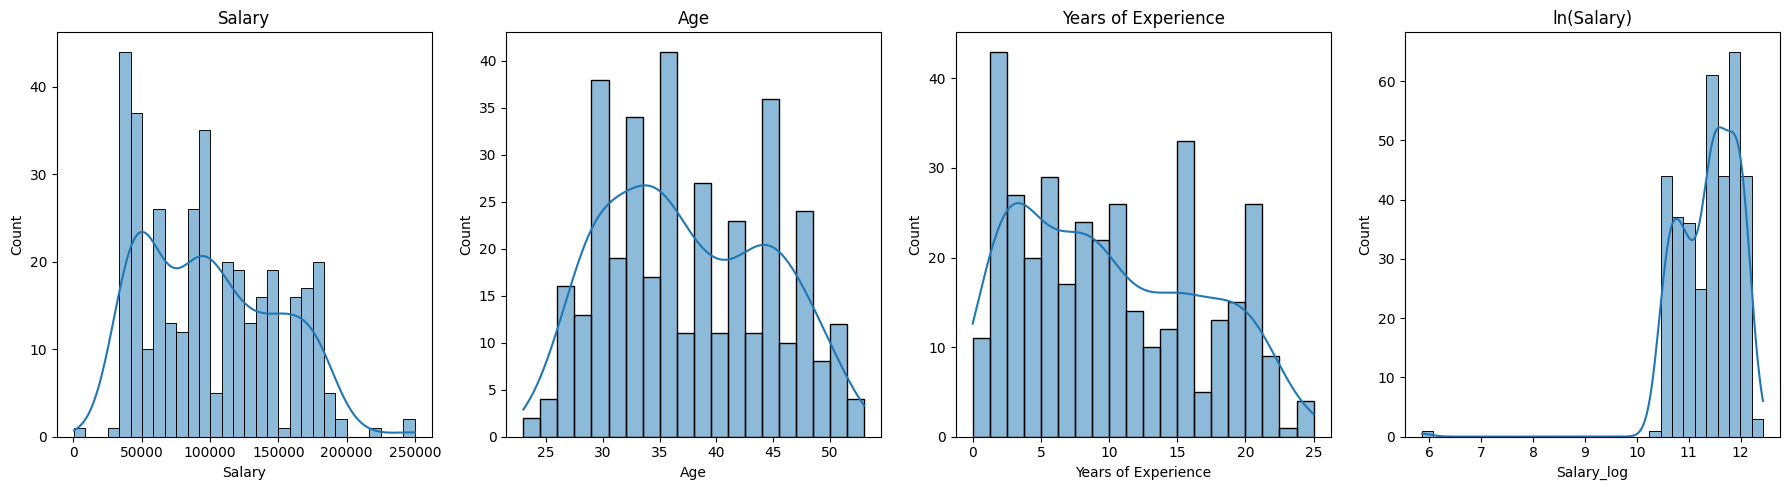


 Amount of rows with job titles that appear more than 6 times: 84
 Job Titles with more than 6 repetitions:
Job Title
Director of Marketing                    12
Director of Operations                   10
Senior Business Analyst                  10
Senior Marketing Manager                  8
Senior Marketing Analyst                  8
Junior Business Analyst                   8
Senior Project Manager                    7
Senior Data Scientist                     7
Junior Business Development Associate     7
Senior Financial Analyst                  7
Name: count, dtype: int64


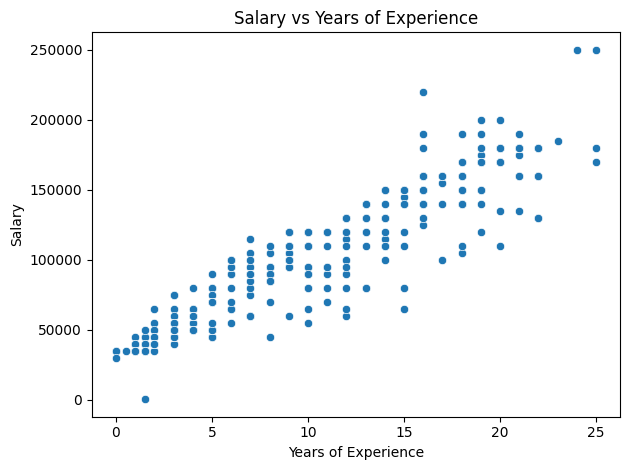

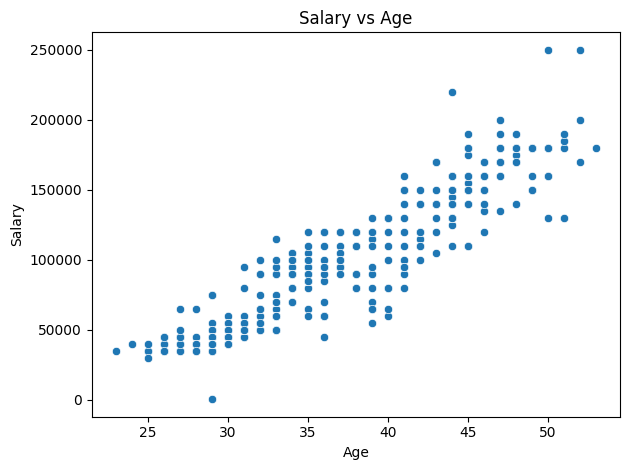

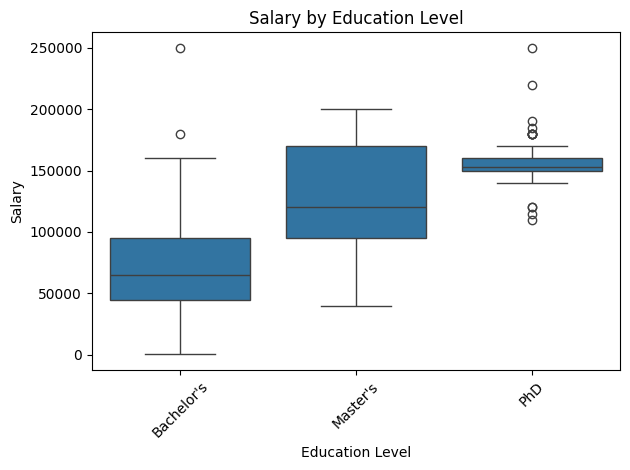

In [3]:

df_merged_exp = df_people.merge(df_salary, on="id", how="left")


# Drop null rows and apply log transform to salary (based on earlier EDA)
df_clean_exp = df_merged_exp.dropna().copy()
df_clean_exp["Salary_log"] = np.log(df_clean_exp["Salary"])
#Plotting different data distributions.
eda.plot_distributions(df_clean_exp)
eda.count_job_titles(df_clean_exp, threshold=6)

#Uncomment for plot relating gender (read README.md)
#eda.plot_salary_by_gender(df_clean_exp)
#eda.gender_salary_stats(df_clean_exp)
#eda.plot_kde_salary_by_gender(df_clean_exp)


plot_numeric_feature_vs_target(df_clean_exp, "Years of Experience")
plot_numeric_feature_vs_target(df_clean_exp, "Age")
plot_categorical_feature_vs_target(df_clean_exp, "Education Level")

To get a sense of how the input features relate to salary, I plotted them against the target (in this case, the actual salary, not the log).

1. Years of Experience vs Salary
The plot shows a clear upward trend: the more experience someone has, the higher the salary tends to be. There’s a lot more variation for people with many years of experience, but overall the correlation looks strong. This makes sense and confirms that experience is a key feature.

2. Age vs Salary
There's also a positive trend here, but it’s messier than with experience. Since age and experience are probably correlated, it’s not surprising. Still, it looks like age adds some information, though maybe not as much on its own.

3. Education Level vs Salary
The boxplot shows some differences. people with a PhD usually earn more, and the salaries are more consistent. Master's is a bit more spread out but still higher than Bachelor's. So education level seems useful, though there’s overlap.

In short, the plots confirm that experience is the most solid predictor, and that age and education also help, at least to some degree.

### 4. Preprocessing

Loads and merges both datasets, removes null rows, and adds a log-transformed Salary column.

Everything here is done through `prepare_data()` inside `src/preprocessing.py`.


In [4]:
# Load and clean data (null removal + log transform on Salary)

df_clean = prepare_data("data/people.csv", "data/salary.csv")
#df_clean.head()


###  5. Feature Transformation

We apply:
- One-hot encoding to `Education Level`
- Job Title grouping (threshold-based)

Handled by `transform_features()` inside `src/features.py`.


In [5]:

job_title_threshold = 3  #Minimum count to keep job title (else grouped as "other")
X, y = transform_features(df_clean, job_threshold=job_title_threshold)



###  6. Model Training & Evaluation

We train a Linear Regression model  or Random forest model and evaluate its performance using:
- MAE & RMSE
- 95% confidence intervals (via bootstrap)
- Comparison with a DummyRegressor

All metrics are printed.

To check how well the selected model was doing, I used two metrics:

MAE : tells me on average how far off the predictions are from the real salaries, in actual dollar terms. It’s pretty straightforward and easy to read.

RMSE : similar idea, but it penalizes bigger mistakes more. So if the model messes up badly on a few predictions, RMSE is gonna reflect that more than MAE.

I applied both AFTER reversing the log transformation, so the results are in REAL SALARY scale (not ln).
Also added a DummyRegressor as a baseline which is  basically a dumb model that always predicts the mean salary (just to have a reference). The goal was to check if my model was doing better than doing almost nothing.


In [ ]:
#model_type = "random_forest"
model_type = "linear" # Uncomment to use linear regression
random_state = 42


# Split data into training and testing sets
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2, random_state=random_state)

if model_type == "linear":
    model = LinearRegression()
elif model_type == "random_forest":
    model = RandomForestRegressor(n_estimators=100, random_state=random_state)
else:
    raise ValueError("Invalid model type.  Choose 'linear' or 'random_forest'.")

# Train the Model
model = train_model(X_train, y_train, model)

# Evaluate the Model
evaluate_model(model, X_test, y_test)


 Model used: LinearRegression

 performance on test:
----------------------------------
 Model Evaluation Summary:
----------------------------------
 MAE: $12,479.65 (on average, predictions deviate this much from actual salaries)
95% Confidence Interval for MAE: $9,422.02 – $16,138.46

RMSE: $18,731.27 
95% Confidence Interval for RMSE: $12,830.38 – $24,581.25

Comparison vs baseline (dum. regressor using mean):
--------------------------------------------------------
 MAE (Dummy): $40,703.57 -  improvement: $28,223.92
 RMSE (Dummy): $50,706.82  -  improvement: $31,975.55


### 7. Predicting on New Input Data

If a CSV file containing new records is found (named `predict_sample.csv`), we apply the trained model to generate predicted salaries.

This allows the user to calculate salaries using different independant variables.

If the file is not found, the block is skipped safely.


In [7]:

prediction_file = "data/predict_sample.csv"                     

# Check if file exists
if os.path.exists(prediction_file):
    print("Prediction file found. Running predictions\n")

    new_predictions = predict_from_csv(prediction_file, model, job_threshold=job_title_threshold)

    # Show results
    print("Predicted salaries for new input:\n")
    print(new_predictions[["Age", "Education Level", "Job Title", "Years of Experience", "Predicted Salary"]])

else:
    print(f"File '{prediction_file}' not found. Skipping prediction block.")





Prediction file found. Running predictions

 diploma, technical, bachelor's, phd, master's, high school
Saved rows to 'predictions.db' in table 'predictions'
Predicted salaries for new input:

   Age Education Level                    Job Title  Years of Experience  Predicted Salary
0   46             PhD        Senior Data Scientist                 18.0     168792.896878
1   33      Bachelor's    Junior Operations Manager                  5.0      57200.940512
2   37        Master's    Senior Software Architect                  9.0      94927.950276
3   51        Master's  Director of Human Resources                 21.0     213927.489691
4   30      Bachelor's  Junior Marketing Specialist                  3.0      48826.744016
5   43      Bachelor's       Senior Project Manager                 15.0     106323.746509
6   27        Master's    Junior Research Scientist                  1.5      54729.794243
7   29         Diploma                 Data Analyst                  4.0      4